In [1]:
%%capture
# install the following packages if required
!pip install pingouin
!pip install pyreadstat

In [2]:
#data handling and processing libraries
import pandas as pd
import numpy as np

#plotting and visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#PCA and Standardization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#statistical package (similar to SciPy)
#https://pingouin-stats.org/
import pingouin as pgstats

#other helper libraries
import copy
import warnings

#changing pandas configuration to be able to display all rows and columns, unless specificed
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
class PCAbox():
    
    """
    Principal Component Analysis
    
    Initiation (parameters required)
    --------------------------------
        * variables (columns) to be selected for the construct as a list
        * a dictionary with mappings to replace text choices (as keys) with numbers (as values)
        * a dictionary with selected column names (as keys) and question text (as values)
        
    Cleaning operations
    -------------------
        * dropping rows having "any" null values
        * replacements
        * standardizing, if specificed
    
    Methods
    -------
        corr_matrix: 
            correlation matrix/heatmap of columns in a given dataframe (default: cleaned dataframe of selected columns)
            
        run_pca: 
            executes principal component analysis for a given dataframe (note: no output at this step)
            
        variance_table:
            ouputs a dataframe having variance of each PC, % of variance, cumilative variance %
            
        loadings_plot: 
            gives component loadings of PCs with respect to the intial variables (default: PC1 and PC2)
            
        correlated_component_loads:
            correlation between principal components and initial variables (output as heatmap)
        
        // note: the correlated_component_loads and the loadings_plot can be used together 
        to select variables to test for reliability using cronbachs_aplha //
                
        cronbachs_aplha: 
            outputs a reliability score for selected columns, defined as 
            "measure of internal consistency, that is, how closely related a set of items are as a group"
            (ref: https://stats.idre.ucla.edu/spss/faq/what-does-cronbachs-alpha-mean/) 
                
        cronbachs_aplha_table:
            a dataframe with cronbachs_aplha for each of different combinations of variables
        
        best_indicators:
            the combination of indicators have the highest score from cronbachs_aplha_table
    """
    
    def __init__(self, replacement_dict, variables, standardize=False):
        self.df_main = copy.deepcopy(df)
        self.selection_cols = variables.keys()
        self.replacement_dict = replacement_dict
        self.variable_labels_dict = variables
        self.selection_df = self.__cleaner(standardize=standardize)
        
    def __cleaner(self, standardize = False):
        
        """
        → Rows having "any" null value are being dropped, as compared to "pair-wise" in SPSS, as scikit-learn's
        implementation of PCA will not work even if an observation has only one NaN value.
        → By default, the standaridization will not be perfomed. Although it is generally recommended to scale 
        features before performing PCA, the range of all the variables is within 1-5 and they are oridinal, so
        the difference between scales of variables is zero. If required, set standardize=True during initiation.        
        """
        
        warnings.filterwarnings('ignore')
        self.selection_df = self.df_main[self.selection_cols]
        self.selection_df.dropna(axis=0, how='any', inplace=True)
        self.selection_df.reset_index(drop=True, inplace=True)
        self.selection_df.replace(to_replace=self.replacement_dict, inplace=True)
        if standardize == False:
            return self.selection_df
        elif standardize == True:
            standardizer = StandardScaler()
            self.selection_df = standardizer.fit_transform(self.selection_df)
            return self.selection_df
    
    def corr_matrix(self, dataframe=None, heatmap=True):
        
        """
        Parameters
        ----------
            dataframe: default is the cleaned dataframe of selected columns
            heatmap: default is True
        
        Output
        ------
            default: correlation matrix as heatmap
            if heatmap==False: correlation matrix as dataframe
        """
        
        if dataframe==None:
            dataframe=copy.deepcopy(self.selection_df)
        if heatmap==True: 
            sns.heatmap(dataframe.corr(), annot=True)
            plt.show()
        else:
            return round(dataframe.corr(), 2)
    
    def run_pca(self, n_components=None):
        
        """
        Parameters
        ----------
            n_components: number of principal components to select (default is None i.e. all will be selected)
            
        Output
        ------
            No output will be return, but a model will be created and stored in the object.
        """
        
        self.model = PCA(n_components=n_components)
        self.model.fit(self.selection_df)
        
    def variance_table(self):
        
        """
        Description
        -----------
            Variance table gives the variance of the original data explained by each of the principal components.       
            
        Parameters
        ----------
            None; based on the model created by run_pca
            
        Output
        ------
            dataframe with the columns for each of the principal components: 
                absolute variance explained
                percentage of variance explained
                cuminlative percentage of the variance explained        
        """
        
        self.variance_df = pd.DataFrame(np.around(self.model.explained_variance_, 3), columns = ['abs Variance'])
        self.variance_df['Variance %'] = np.around(self.model.explained_variance_ratio_*100, 3)
        self.variance_df['Cumulative %'] = np.around(np.cumsum(self.model.explained_variance_ratio_)*100, 3)
        self.variance_df.index, self.variance_df.index.name = np.arange(1, len(self.variance_df)+1), 'PC'
        return self.variance_df
    
    def loadings_plot(self, x_component = 1, y_component = 2, legend_anchor = (0, 0), legend_loc = 'upper right'):
        
        """
        Description
        -----------
            Loadings plot shows the influence or rather how strongly each of the intial variables
            influces the selected principal components
            
        Parameters
        ----------
            x_component -> int: PC_n (default: PC1)
            y_component -> int: PC_n (default: PC2)
            legend_anchor -> tuple: used to position the legend in conjunction with legend_loc (default: (0, 0))
            legend_loc -> str: location of the legend (default = 'upper right')
                more information about legend at https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
        
        Output
        ------
            loadings plot with PC1 on x-axis and PC2 on y-axis (default)
        """
        
        self.x_component, self.y_component = x_component - 1, y_component - 1
        
        self.x_loadings = self.model.components_[self.x_component]
        self.y_loadings = self.model.components_[self.y_component]
        
        self.x_transformed = self.model.transform(self.selection_df)[:, self.x_component]
        self.y_transformed = self.model.transform(self.selection_df)[:, self.y_component]
        
        self.color_list = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", \
                      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
        self.plot_variables = self.selection_df.columns.values
        
        for i in range(len(self.x_loadings)):
            plt.arrow(0, 0, self.x_loadings[i]*max(self.x_transformed), self.y_loadings[i]*max(self.y_transformed),
                     label=f'{self.plot_variables[i]}: {self.variable_labels_dict[self.plot_variables[i]]}',
                     color=self.color_list[i], alpha=0.7, width=0.025, head_width=0.0025)
            plt.text(self.x_loadings[i]*max(self.x_transformed)*1, self.y_loadings[i]*max(self.y_transformed)*0.75,
                     list(self.plot_variables)[i], color=self.color_list[i], fontweight='bold')
            
        plt.axhline(y=0, color='black', linestyle = '--', linewidth = 1)
        plt.axvline(x=0, color='black', linestyle = '--', linewidth = 1)
        plt.legend(loc=legend_loc, bbox_to_anchor = legend_anchor)
        plt.xlabel(f'Principal Component {x_component}')
        plt.ylabel(f'Principal Component {y_component}')
        plt.title('Loadings Plot')
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.show()
    
    def correlated_component_loads(self, heatmap=True, pc_n=2, mask=0.5):
        
        """
        Description
        -----------
            The table/heatmap gives correlation between the values of intial variables and 
            the values of selected principal components after transformation.
            
        Parameters
        ----------
            heatmap -> True/False: ouput as a heatmap (if True, also default); as a dataframe (if False)
            pc_n -> int: number of principal components to select (default = 2)
            mask -> float: values/cells between the mask value to hide to increase readability (default = 0.5) 
            
        Output
        ------
            heatmap/dataframe of correlations between intial variables and the principal components.
        """
        
        self.correlated_components_df = pd.concat([self.selection_df, 
                                              pd.DataFrame(self.model.transform(self.selection_df),
                                                           columns=[f'PC{i}' for i in range(1, self.selection_df.shape[1]+1)])],
                                             axis=1).corr().iloc[:self.selection_df.shape[1], self.selection_df.shape[1]:]
        
        if heatmap==True:
            mask_df = abs(self.correlated_components_df.iloc[:,:pc_n]) < mask
            sns.heatmap(abs(self.correlated_components_df.iloc[:,:pc_n]), annot=True, linewidths=.5, 
                        mask=mask_df, vmax=1, cmap='icefire')
            plt.show()
        else:
            return self.correlated_components_df.iloc[:,:pc_n].apply(lambda x:np.where(abs(x)<mask, '*', round(x, 2)))
    
    def cronbachs_alpha(self, cols):
        
        """
        Description
        -----------
            According to https://stats.idre.ucla.edu/spss/faq/what-does-cronbachs-alpha-mean/, 
            "cronbach’s alpha is a measure of internal consistency, that is, 
            how closely related a set of items are as a group"
        
        Parameters
        ----------
            cols -> list: list of columns from the dataframe of selected columns to calculate cronbach’s alpha for
            
        Output
        ------
            cronbach's alpha value (float)
        """
        
        return round(pgstats.cronbach_alpha(self.selection_df[cols])[0],3)
    
    def cronbachs_alpha_table(self, constructs={}):
        
        """
        Parameters
        ----------
            constructs -> dictionary (key: value -> list): combinations of columns to calculate cronbach's alpha for
                example: {'a': ['col_1', 'col_2', 'col_3'], 'b': ['col_1', 'col_3', 'col_4', 'col_5']}
        
        Output
        ------
            dataframe with cronbach's alpha for each of the values        
        """
        
        self.constructs = constructs
        self.ca_df = pd.DataFrame(columns=['Variables', 'Reliability score'])
        
        for index, i in enumerate(self.constructs.values()):
            self.ca_df.loc[index, 'Variables'] = i
            self.ca_df.loc[index, 'Reliability score'] = self.cronbachs_alpha(i)
            
        return self.ca_df
    
    def best_indicators(self):
        
        """
        Output
        ------
            the combination of best indicators along with their reliability score for the combinations given
            while calling cronbachs_alpha_table method.
        """
        
        for index in range(len(self.constructs)):
            if self.ca_df.loc[index, 'Reliability score'] == max(self.ca_df['Reliability score'].values):
                best_indicators = self.ca_df.loc[index, 'Variables']
                best_indicators_ca = self.ca_df.loc[index, 'Reliability score']
                if best_indicators_ca < 0.7:
                    print(f'The best indicators are {best_indicators}, however, please note that the reliability score ({best_indicators_ca}) is below 0.7, and they may not be adequate enough to measure the construct.')
                else:
                    print(f'The best indicators are {best_indicators} with a reliability score of {best_indicators_ca}.')

In [4]:
df = pd.read_spss('2020YoY_2019compliant_w5aud.sav')

## Table of Contents
→ <a href='#summary'>Summary of Conclusions</a>
- <a href='#empowerment'>Empowerment</a>
- <a href='#engagement'>Engagement</a>
- <a href='#belonging'>Feelings of Belonging</a>
- <a href='#awareness'>Awareness of Self & Others</a>
- <a href='#collaboration'>Collaborative Intention</a>
- <a href='#movement_leadership'>Movement Leadership</a>
- <a href='#movement_strategy'>Movement Strategy (Leadership)</a>
- <a href='#inclusive_interactions'>Inclusive Interactions</a>
- <a href='#inclusive_culture'>Inclusive Culture</a>
- <a href='#diversity_commitment'>Individual Commitment to Diversity</a>


<a id='empowerment'></a>
## Empowerment

In [6]:
replacements_a = {'Strongly disagree': 1,
                  'Disagree': 2,
                  'Neither agree nor disagree': 3,
                  'Neither': 3,
                  'Agree': 4,
                  'Strongly agree': 5,
                  'Strongly Agree': 5}

empowerment_variables = {'C18_1': 'It has been easy to learn the editing tools',
                         'C18_2': 'It has been easy to learn editing policies',
                         'C18_3': 'Learning to edit has been easy',
                         'C18_4': 'I feel like I understand the rules for editing content',
                         'C18_5': 'Other editors have been kind',
                         'C18_6': 'Other editors have been helpful'}

empowerment_pca = PCAbox(replacements_a, empowerment_variables)
empowerment_pca.run_pca()

In [7]:
empowerment_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          3.072      56.518        56.518
2          1.054      19.385        75.903
3          0.437       8.037        83.940
4          0.398       7.316        91.255
5          0.261       4.797        96.052
6          0.215       3.948       100.000

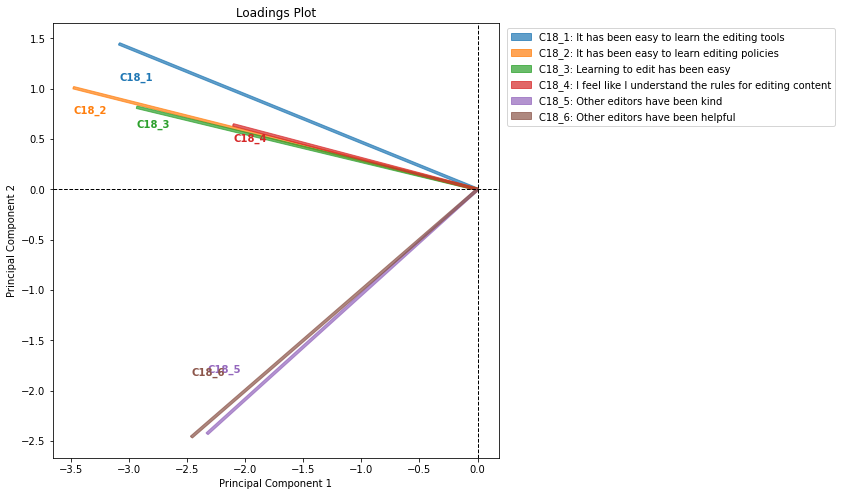

In [9]:
empowerment_pca.loadings_plot(legend_anchor=(1.765,1))

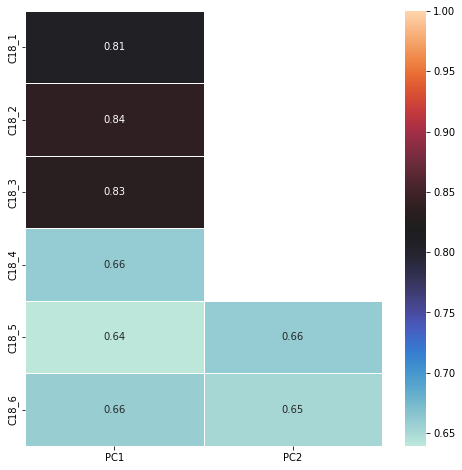

In [13]:
empowerment_pca.correlated_component_loads()

In [14]:
empowerment_constructs = {'a': ['C18_1', 'C18_2', 'C18_3', 'C18_4', 'C18_5', 'C18_6'],
                          'b': ['C18_1', 'C18_2', 'C18_3'],
                          'c': ['C18_5', 'C18_6']}

empowerment_pca.cronbachs_alpha_table(constructs=empowerment_constructs)

Variables Reliability score
0  [C18_1, C18_2, C18_3, C18_4, C18_5, C18_6]             0.838
1                       [C18_1, C18_2, C18_3]             0.856
2                              [C18_5, C18_6]             0.827

In [15]:
empowerment_pca.best_indicators()

The best indicators are ['C18_1', 'C18_2', 'C18_3'] with a reliability score of 0.856.


#### Conclusion
- 'C18_1', 'C18_2', 'C18_3' have the highest reliability (internal consistency) among all other combinations, to measure "Empowerment".
    - 'C18_4' may be dropped, as the wording is also similar to 'C18_2'
- 'C18_5', 'C18_6' are indicating towards a new construct with a substantial reliaiblity score.

<a id='engagement'></a>
## Engagement

In [16]:
engagement_variables = {'AA13_1': 'I would recommend Wikimedia projects as a great place to contribute',
                        'AA13_2': 'The vision inspires me to contribute more to Wikimedia projects than I would somewhere else', 
                        'AA13_3': 'I take pride in contributing to the Wikimedia projects', 
                        'AA13_4': 'I expect to be contributing to Wikimedia two years from now', 
                        'SI13_5_r': 'I often think about quitting as a contributor to Wikimedia projects'}

engagement_pca = PCAbox(replacements_a, engagement_variables)
engagement_pca.run_pca()

In [17]:
engagement_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          2.500      53.829        53.829
2          1.100      23.686        77.515
3          0.417       8.980        86.495
4          0.348       7.500        93.994
5          0.279       6.006       100.000

In [18]:
engagement_pca.loadings_plot(legend_anchor=(2,1))

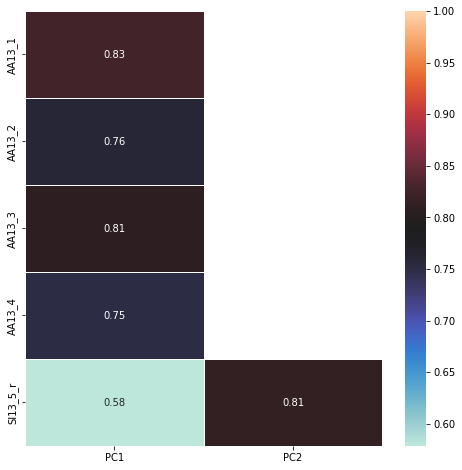

In [19]:
engagement_pca.correlated_component_loads()

In [20]:
engagement_constructs = {'a': ['AA13_1', 'AA13_2', 'AA13_3', 'AA13_4', 'SI13_5_r'],
                         'b': ['AA13_1', 'AA13_2', 'AA13_3', 'AA13_4'],
                         'c': ['AA13_1', 'AA13_3']}

engagement_pca.cronbachs_alpha_table(constructs=engagement_constructs)

Variables Reliability score
0  [AA13_1, AA13_2, AA13_3, AA13_4, SI13_5_r]             0.784
1            [AA13_1, AA13_2, AA13_3, AA13_4]             0.841
2                            [AA13_1, AA13_3]             0.773

In [21]:
engagement_pca.best_indicators()

The best indicators are ['AA13_1', 'AA13_2', 'AA13_3', 'AA13_4'] with a reliability score of 0.841.


#### Conclusion
- AA13_1, AA13_2, AA13_3, AA13_4 have the highest reliability (internal consistency), among other indicators, to measure "Engagement".

<a id='belonging'></a>
## Feelings of Belonging

In [22]:
belonging_variables = {'SI13_1': 'I feel like I belong in the Wikimedia movement',
                             'SI13_2': 'I feel respected in the Wikimedia movement',
                             'SI13_3': 'I feel that my voice is heard in decisions made in my community',
                             'SI13_4': 'I feel that my voice is heard in decisions made in the Wikimedia movement',
                             'SI13_5': 'There is open and honest communication between different organizations and groups in the Wikimedia movement',
                             'SI13_6': 'I am satisfied with the Wikimedia movement\'s decision-making processes',
                             'SI13_7': 'I often think about quitting as a contributor to Wikimedia projects',
                             'SI13_8': 'My contributions to Wikimedia projects are often challenged or removed unfairly or inappropriately'}

belonging_pca = PCAbox(replacements_a, belonging_variables)
belonging_pca.run_pca()

In [23]:
belonging_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          4.210      47.257        47.257
2          1.468      16.481        63.738
3          0.762       8.557        72.295
4          0.713       8.009        80.304
5          0.555       6.233        86.537
6          0.451       5.066        91.603
7          0.398       4.464        96.067
8          0.350       3.933       100.000

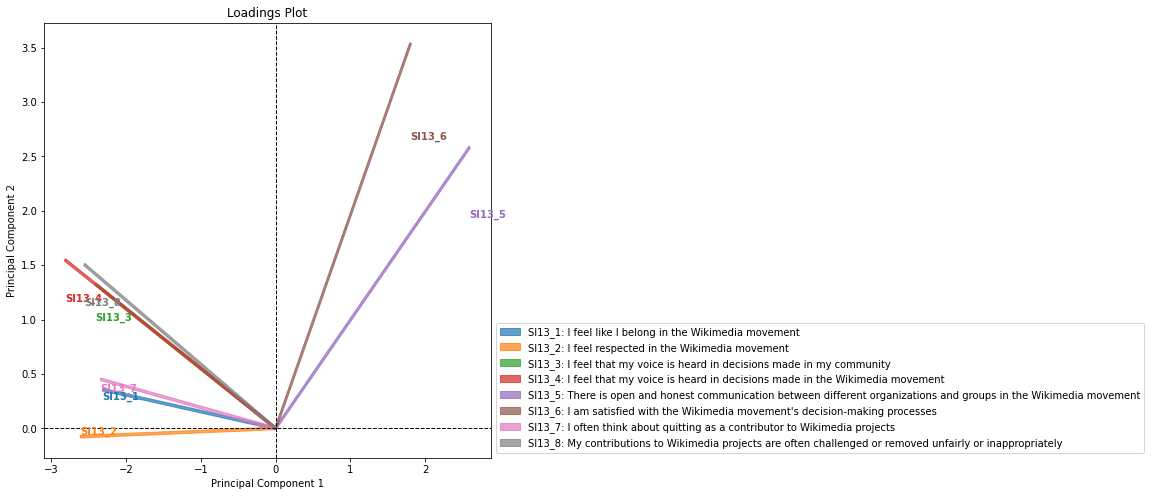

In [24]:
belonging_pca.loadings_plot(legend_anchor=(1, 0), legend_loc='lower left')

In [25]:
belonging_pca.correlated_component_loads()

In [26]:
belonging_constructs = {'a': ['SI13_1', 'SI13_2', 'SI13_3', 'SI13_4', 'SI13_5', 'SI13_6', 'SI13_7', 'SI13_8'],
                        'b': ['SI13_1', 'SI13_2', 'SI13_3', 'SI13_4', 'SI13_7', 'SI13_8'],
                        'c': ['SI13_2', 'SI13_3', 'SI13_4', 'SI13_7', 'SI13_8']}

belonging_pca.cronbachs_alpha_table(constructs=belonging_constructs)

Variables Reliability score
0  [SI13_1, SI13_2, SI13_3, SI13_4, SI13_5, SI13_...             0.566
1   [SI13_1, SI13_2, SI13_3, SI13_4, SI13_7, SI13_8]             0.852
2           [SI13_2, SI13_3, SI13_4, SI13_7, SI13_8]              0.84

In [27]:
belonging_pca.best_indicators()

The best indicators are ['SI13_1', 'SI13_2', 'SI13_3', 'SI13_4', 'SI13_7', 'SI13_8'] with a reliability score of 0.852.


#### Conclusion
- SI13_1, SI13_2, SI13_3, SI13_4, SI13_7, SI13_8 have the highest reliability (internal consistency) among other indicators,<br> to measure "Feelings of Belonging"

<a id='awareness'></a>
## Awareness of Self & Others

In [28]:
awareness_variables = {'SI07_5_r': 'People lack self-awareness',
                       'SI07_6_r': 'People are not aware of their own defensiveness to the situation at hand',
                       'SI07_7': 'People are aware of their biases and patterns of behavior',
                       'SI07_8': 'People seek out and value feedback',
                       'SI07_9': 'People know how to motivate others'}

awareness_pca = PCAbox(replacements_a, awareness_variables)
awareness_pca.run_pca()

In [29]:
awareness_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          1.687      35.353        35.353
2          1.143      23.942        59.295
3          0.805      16.876        76.171
4          0.583      12.219        88.389
5          0.554      11.611       100.000

In [30]:
awareness_pca.loadings_plot(legend_anchor=(2.05, 1))

In [31]:
awareness_pca.correlated_component_loads(pc_n=3)

In [32]:
awareness_constructs = {'a': ['SI07_5_r', 'SI07_6_r', 'SI07_7', 'SI07_8', 'SI07_9'],
                        'b': ['SI07_7', 'SI07_8', 'SI07_9'],
                        'c': ['SI07_5_r', 'SI07_6_r'],
                        'd': ['SI07_7', 'SI07_8']}

awareness_pca.cronbachs_alpha_table(constructs=awareness_constructs)

Variables Reliability score
0  [SI07_5_r, SI07_6_r, SI07_7, SI07_8, SI07_9]              0.52
1                      [SI07_7, SI07_8, SI07_9]             0.534
2                          [SI07_5_r, SI07_6_r]             0.524
3                              [SI07_7, SI07_8]             0.365

In [33]:
awareness_pca.best_indicators()

The best indicators are ['SI07_7', 'SI07_8', 'SI07_9'], however, please note that the reliability score (0.534) is below 0.7, and they may not be adequate enough to measure the construct.


#### Conclusion
- The reliability scores of indicators suggested by the component loads from PCA are not substantial to draw any conclusion, and similar is the case with other combinations of indicators. The construct may needs to be revisited to identify better factors.

<a id='collaboration'></a>
## Collaborative Intention

In [34]:
collaboration_variables = {'SI07_1': 'People are sincerely interested in supporting each other',
                           'SI07_2': 'People are committed to building long-term cooperative relationships',
                           'SI07_3': 'People with collaborative projects work together well',
                           'SI07_4': 'People are good at reaching out when they need to consult with others'}

collaboration_pca = PCAbox(replacements_a, collaboration_variables)
collaboration_pca.run_pca()

In [35]:
collaboration_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          2.408      52.992        52.992
2          0.801      17.635        70.627
3          0.707      15.556        86.183
4          0.628      13.817       100.000

In [36]:
collaboration_pca.loadings_plot(legend_anchor=(2,1))

In [37]:
collaboration_pca.correlated_component_loads()

In [38]:
collaboration_constructs = {'a': ['SI07_1', 'SI07_2', 'SI07_3', 'SI07_4'],
                            'b': ['SI07_1', 'SI07_2', 'SI07_4']}

collaboration_pca.cronbachs_alpha_table(constructs=collaboration_constructs)

Variables Reliability score
0  [SI07_1, SI07_2, SI07_3, SI07_4]             0.704
1          [SI07_1, SI07_2, SI07_4]              0.66

In [39]:
collaboration_pca.best_indicators()

The best indicators are ['SI07_1', 'SI07_2', 'SI07_3', 'SI07_4'] with a reliability score of 0.704.


#### Conclusion
- SI07_1, SI07_2, SI07_3, SI07_4 have the highest reliability (internal consistency) among other indicators, to measure "Collaborative Intention".

<a id='movement_leadership'></a>
## Movement Leadership

In [40]:
movement_leadership_variables = {'AA05_1': 'The Wikimedia Foundation communicates well about their projects and initiatives',
                                       'AA05_2': 'I am confident in the Wikimedia Foundation\'s ability to support the global movement',
                                       'SI13_3': 'There is open and honest communication between different organizations and groups in the Wikimedia movement',
                                       'SI13_4': 'I am satisfied with the Wikimedia movements decision-making processes'}

movement_leadership_pca = PCAbox(replacements_a, movement_leadership_variables)
movement_leadership_pca.run_pca()

In [41]:
movement_leadership_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          2.904      64.321        64.321
2          0.718      15.908        80.228
3          0.470      10.402        90.630
4          0.423       9.370       100.000

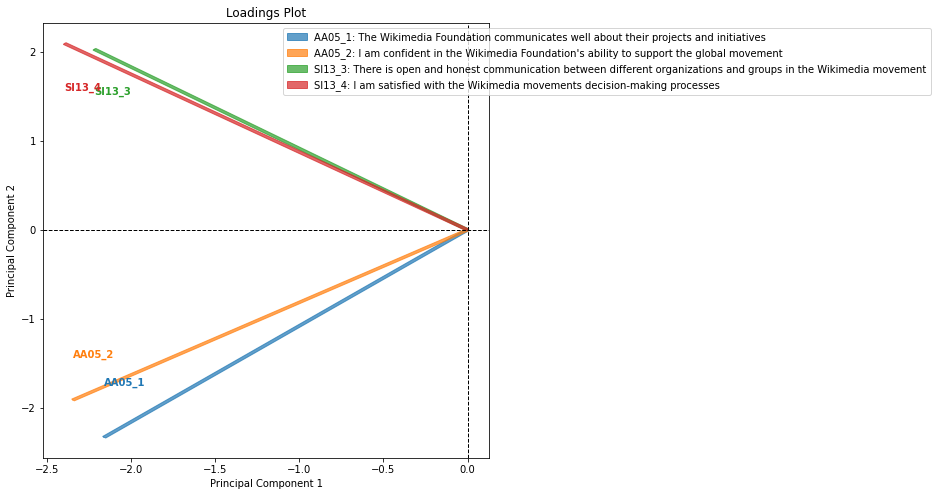

In [42]:
movement_leadership_pca.loadings_plot(legend_anchor=(2,1))

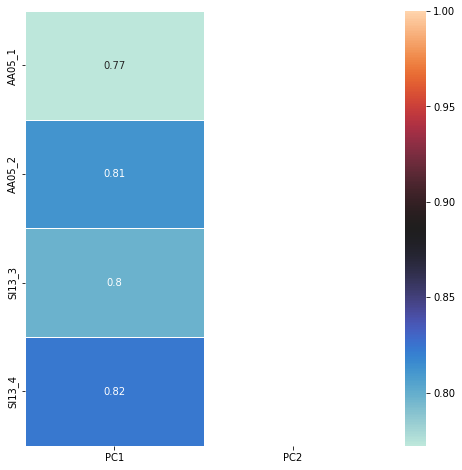

In [43]:
movement_leadership_pca.correlated_component_loads()

In [44]:
movement_leadership_constructs = {'a': ['AA05_1', 'AA05_2', 'SI13_3', 'SI13_4'],
                                  'b': ['SI13_3', 'SI13_4'],
                                  'c': ['AA05_1', 'AA05_2']}

movement_leadership_pca.cronbachs_alpha_table(constructs=movement_leadership_constructs)

Variables Reliability score
0  [AA05_1, AA05_2, SI13_3, SI13_4]             0.814
1                  [SI13_3, SI13_4]             0.768
2                  [AA05_1, AA05_2]             0.735

In [45]:
movement_leadership_pca.best_indicators()

The best indicators are ['AA05_1', 'AA05_2', 'SI13_3', 'SI13_4'] with a reliability score of 0.814.


#### Conclusion
- AA05_1, AA05_2, SI13_3, SI13_4 have the highest reliability (internal consistency) among other indicators, to measure "Movement Leadership".

<a id='movement_strategy'></a>
## Movement Strategy (Leadership)

In [46]:
movement_strategy_variables = {'AA06_1': 'The 2030 movement strategy process is moving in the right direction',
                               'AA06_2': 'I have faith in the leadership of the 2030 movement strategy process',
                               'AA06_3': 'I understand the goals of the 2030 movement strategy process', 
                               'AA06_4': 'I know what the 2030 strategic direction is for'}

movement_strategy_pca = PCAbox(replacements_a, movement_strategy_variables)
movement_strategy_pca.run_pca()

In [47]:
movement_strategy_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          3.285      69.129        69.129
2          0.962      20.246        89.374
3          0.261       5.482        94.856
4          0.244       5.144       100.000

In [48]:
movement_strategy_pca.loadings_plot(legend_anchor=(2,1))

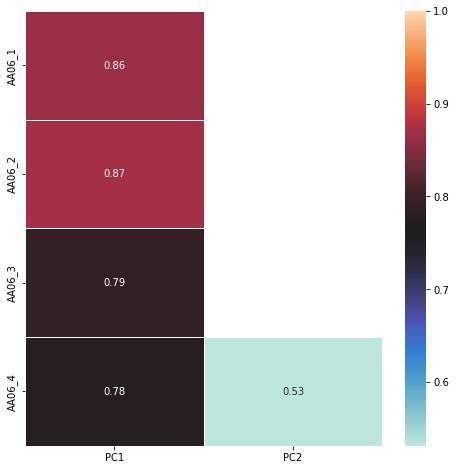

In [49]:
movement_strategy_pca.correlated_component_loads()

In [50]:
movement_strategy_constructs = {'a': ['AA06_1', 'AA06_2', 'AA06_3', 'AA06_4'],
                                'b': ['AA06_1', 'AA06_2'],
                                'c': ['AA06_3', 'AA06_4']}

movement_strategy_pca.cronbachs_alpha_table(constructs=movement_strategy_constructs)

Variables Reliability score
0  [AA06_1, AA06_2, AA06_3, AA06_4]             0.848
1                  [AA06_1, AA06_2]             0.891
2                  [AA06_3, AA06_4]             0.865

In [51]:
movement_strategy_pca.best_indicators()

The best indicators are ['AA06_1', 'AA06_2'] with a reliability score of 0.891.


### Conclusion
- For Movement Strategy (Leadership), indicators AA06_1 and AA06_2 display the highest internal consistency for measurement.

<a id='inclusive_interactions'></a>
## Inclusive Interactions

In [52]:
inclusive_interactions_variables = {'SI09_1': 'Contributors of different backgrounds interact well in my Wikimedia project or community', 
                                          'SI09_2': 'Contributors of different backgrounds are valued equally in my Wikimedia project or community', 
                                          'SI09_3_r': 'Racial, ethnic, and gender-based jokes are tolerated in my Wikimedia project or community', 
                                          'SI09_4': 'My Wikimedia project or community provides an environment for the free and open expression of ideas'}

inclusive_interactions_pca = PCAbox(replacements_a, inclusive_interactions_variables)
inclusive_interactions_pca.run_pca()

In [53]:
inclusive_interactions_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          2.523      54.575        54.575
2          1.303      28.176        82.751
3          0.446       9.641        92.392
4          0.352       7.608       100.000

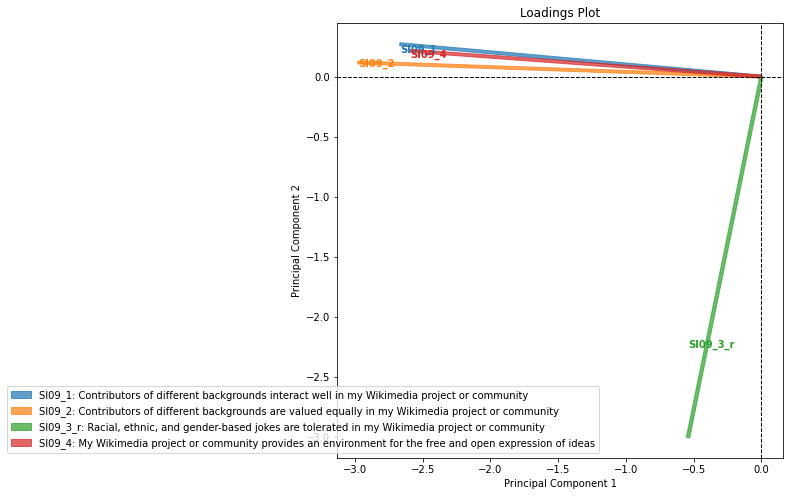

In [54]:
inclusive_interactions_pca.loadings_plot(legend_anchor=(-0.75, 0), legend_loc='lower left')

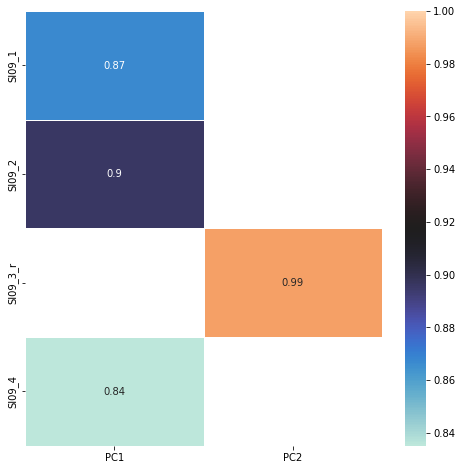

In [55]:
inclusive_interactions_pca.correlated_component_loads()

In [56]:
inclusive_interactions_constructs = {'a': ['SI09_1', 'SI09_2', 'SI09_3_r', 'SI09_4'],
                                     'b': ['SI09_1', 'SI09_2', 'SI09_4']}

inclusive_interactions_pca.cronbachs_alpha_table(constructs=inclusive_interactions_constructs)

Variables Reliability score
0  [SI09_1, SI09_2, SI09_3_r, SI09_4]             0.669
1            [SI09_1, SI09_2, SI09_4]             0.839

In [57]:
inclusive_interactions_pca.best_indicators()

The best indicators are ['SI09_1', 'SI09_2', 'SI09_4'] with a reliability score of 0.839.


#### Conclusion
* For "Inclusive Interactions", the indicators SI09_1, SI09_2, and SI09_4, display the highest internal consistency for measurement. 

<a id='inclusive_culture'></a>
## Inclusive Culture

In [58]:
inclusive_culture_variables = {'SI15_1': 'The Wikimedia movement is making progress with diversity initiatives', 
                                     'SI15_2': 'Different project and contributor groups are treated fairly in the Wikimedia movement', 
                                     'SI15_3': 'In the Wikimedia movement, people appreciate others whose context and cultural background is different from their own'}

inclusive_culture_pca = PCAbox(replacements_a, inclusive_culture_variables)
inclusive_culture_pca.run_pca()

In [59]:
inclusive_culture_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          2.106      70.182        70.182
2          0.550      18.318        88.500
3          0.345      11.500       100.000

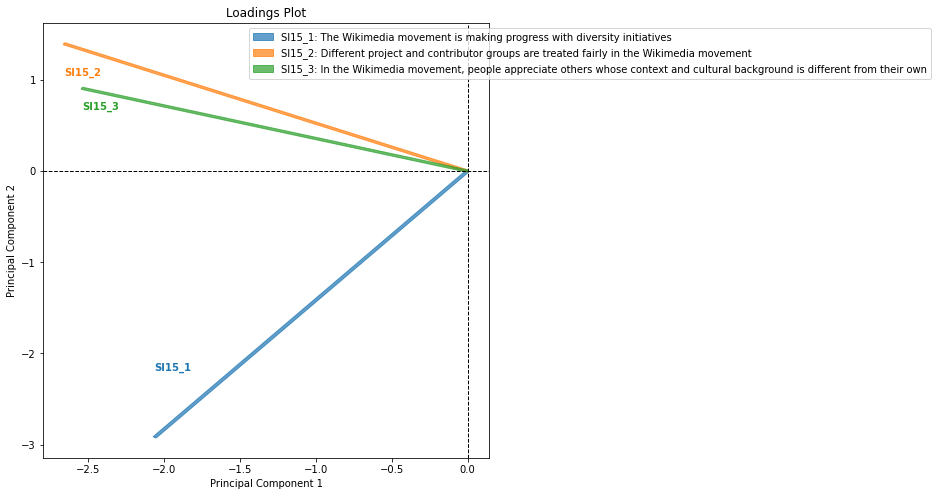

In [60]:
inclusive_culture_pca.loadings_plot(legend_anchor=(2,1))

In [61]:
inclusive_culture_pca.correlated_component_loads()

In [62]:
inclusive_culture_constructs = {'a': ['SI15_1', 'SI15_2', 'SI15_3'],
                                'b': ['SI15_2', 'SI15_3']}

inclusive_culture_pca.cronbachs_alpha_table(constructs=inclusive_culture_constructs)

Variables Reliability score
0  [SI15_1, SI15_2, SI15_3]             0.782
1          [SI15_2, SI15_3]             0.799

#### Conclusion
* For "Inclusive Culture", the indicators SI15_2 and SI15_3, display the highest internal consistency for measurement. However, it is important to note that, additional indicator SI15_1, only reduces the score by about 2%. So, SI15_1, SI15_2 and SI15_3, together may still be good for measuring "Inclusive Culture" - more data is required to conclude on this.

In [63]:
inclusive_culture_pca.best_indicators()

The best indicators are ['SI15_2', 'SI15_3'] with a reliability score of 0.799.


<a id='diversity_commitment'></a>
## Individual Commitment to Diversity

In [64]:
diversity_commitment_variables = {'SI03_1': 'I am comfortable working with different kinds of people',
                                  'SI03_2': 'I am confident when voicing my opinion, even when it’s different from those around me',
                                  'SI03_3': 'I believe that a diverse community positively impacts the quality of Wikimedia content',
                                  'SI03_4': 'I believe there are community policies and systems in place to respond appropriately to incidents of harassment',
                                  'SI03_5': 'I believe that multiultural collaboration produces positive outcomes'}

diversity_commitment_pca = PCAbox(replacements_a, diversity_commitment_variables)
diversity_commitment_pca.run_pca()

In [65]:
diversity_commitment_pca.variance_table()

abs Variance  Variance %  Cumulative %
PC                                        
1          1.896      44.391        44.391
2          1.080      25.280        69.671
3          0.739      17.310        86.981
4          0.338       7.906        94.887
5          0.218       5.113       100.000

In [66]:
diversity_commitment_pca.loadings_plot(legend_anchor=(2,1))

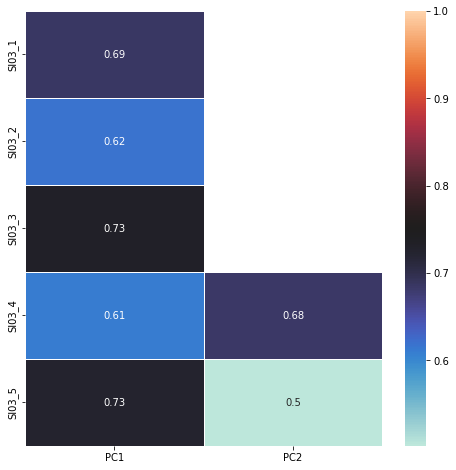

In [67]:
diversity_commitment_pca.correlated_component_loads()

In [68]:
diversity_commitment_constructs = {'a': ['SI03_1', 'SI03_2', 'SI03_3', 'SI03_4', 'SI03_5'],
                                   'b': ['SI03_1', 'SI03_3', 'SI03_5'],
                                   'c': ['SI03_2', 'SI03_4']}

diversity_commitment_pca.cronbachs_alpha_table(constructs=diversity_commitment_constructs)

Variables Reliability score
0  [SI03_1, SI03_2, SI03_3, SI03_4, SI03_5]             0.685
1                  [SI03_1, SI03_3, SI03_5]             0.807
2                          [SI03_2, SI03_4]             0.457

In [69]:
diversity_commitment_pca.best_indicators()

The best indicators are ['SI03_1', 'SI03_3', 'SI03_5'] with a reliability score of 0.807.


#### Conclusion
* For "Individual Commitment to Diversity", the indicators, SI03_1, SI03_3, and SI03_5, display the highest internal consistency.

<a id="summary"></a>
## Summary of Conclusions

In [70]:
themes_dict = {'Empowerment': empowerment_pca,
              'Engagement': engagement_pca,
              'Feelings of Belonging': belonging_pca,
              'Awareness of Self & Others': awareness_pca,
              'Collaborative Intention': collaboration_pca,
              'Movement Leadership': movement_leadership_pca,
              'Movement Strategy (Leadership)': movement_strategy_pca,
              'Inclusive Interactions': inclusive_interactions_pca,
              'Inclusive Culture': inclusive_culture_pca,
              'Individual Commitment to Diversity': diversity_commitment_pca}

for theme, pca in themes_dict.items():
    print(f'\033[1m{theme}:\033[0m')
    pca.best_indicators()
    print('\n')

Empowerment:
The best indicators are ['C18_1', 'C18_2', 'C18_3'] with a reliability score of 0.856.


Engagement:
The best indicators are ['AA13_1', 'AA13_2', 'AA13_3', 'AA13_4'] with a reliability score of 0.841.


Feelings of Belonging:
The best indicators are ['SI13_1', 'SI13_2', 'SI13_3', 'SI13_4', 'SI13_7', 'SI13_8'] with a reliability score of 0.852.


Awareness of Self & Others:
The best indicators are ['SI07_7', 'SI07_8', 'SI07_9'], however, please note that the reliability score (0.534) is below 0.7, and they may not be adequate enough to measure the construct.


Collaborative Intention:
The best indicators are ['SI07_1', 'SI07_2', 'SI07_3', 'SI07_4'] with a reliability score of 0.704.


Movement Leadership:
The best indicators are ['AA05_1', 'AA05_2', 'SI13_3', 'SI13_4'] with a reliability score of 0.814.


Movement Strategy (Leadership):
The best indicators are ['AA06_1', 'AA06_2'] with a reliability score of 0.891.


Inclusive Interactions:
The best indicators are ['SI09_1'